## **Baseline Model For 11785 Project**

Group members: Jerry Yin,
Anqi Xie,
Jiayu Wang,
Haoyu Yang

# Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import math

# Config

In [ ]:
window_size = 60
n_hidden_layers = 2
units = 128
activation = 'relu'
optimizer = 'adam'
loss = 'mse'
epochs = 5
batch_size = 32

# Load Data
The dataset used here is from Yahoo Finance. The past 10 years of data is downloaded, and 90% is used as training data, with the rest 10% used as testing data. Data is normalized to the range of [0,1].

In [ ]:
#load data fromYahoo Finance
end_date = datetime.today()
start_date = end_date - timedelta(days=10*365)
ticker = "000001.SS"
df = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
df = df[['Open', 'High', 'Low', 'Close']].dropna()  #ensure no missing values

data_values = df.values  #(num_days, 4)
num_features = data_values.shape[1]  #4

#split 90% as train data and the rest 10% for testing
train_size = int(len(data_values) * 0.90)
train_data = data_values[:train_size]
test_data  = data_values[train_size:]

#normalize
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Model and Training

In [10]:
#Seqs for training and testing
X_train, y_train = [], []
X_test, y_test = [], []

#training seqs and targets (sequence from (i-window_size) to (i-1) as input, and i-th day close as target)
for i in range(window_size, len(train_scaled)):
    X_train.append(train_scaled[i-window_size:i])
    y_train.append(train_scaled[i, -1])#get close price

#create test sequences within the test_scaled array separately
for i in range(window_size, len(test_scaled)):
    X_test.append(test_scaled[i-window_size:i])
    y_test.append(test_scaled[i, -1])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test   = np.array(X_test),  np.array(y_test)

print("Training sequences shape:", X_train.shape)
print("Testing sequences shape:", X_test.shape)

# Model
model = Sequential()
model.add(LSTM(units, activation=activation, return_sequences=True, input_shape=(window_size, num_features)))
model.add(LSTM(units, activation=activation, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer=optimizer, loss=loss)

#train
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), shuffle=False)


[*********************100%***********************]  1 of 1 completed

Training sequences shape: (2123, 60, 4)
Testing sequences shape: (183, 60, 4)
Epoch 1/5



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - loss: 0.0373 - val_loss: 0.0017
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 5/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - loss: 0.0024 - val_loss: 0.0016


In [12]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 60, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 599,429 (2.29 MB)

 Trainable params: 199,809 (780.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 399,620 (1.52 MB)

# Testing

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Test RMSE: 106.700


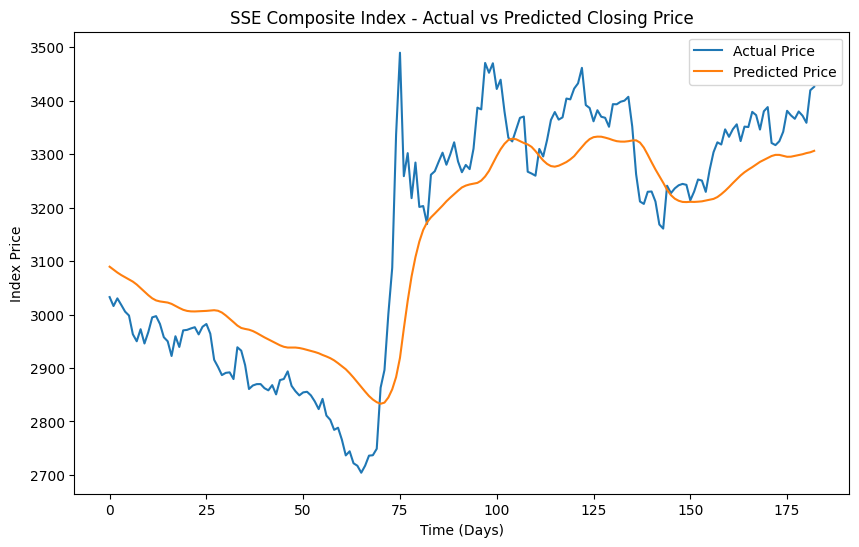

In [11]:
#Test dataset
y_pred_scaled = model.predict(X_test)
close_index = list(df.columns.get_level_values(0)).index('Close')#close column index
close_min = scaler.data_min_[close_index]
close_max = scaler.data_max_[close_index]

# convert y_test and y_pred to original price (now normalized)
y_test_scaled = y_test.reshape(-1)
y_pred_actual = y_pred_scaled * (close_max - close_min) + close_min
y_test_actual = y_test_scaled * (close_max - close_min) + close_min

#test set rmse
rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f"Test RMSE: {rmse:.3f}")

#plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(y_pred_actual, label='Predicted Price')
plt.title('SSE Composite Index - Actual vs Predicted Closing Price')
plt.xlabel('Time (Days)')
plt.ylabel('Index Price')
plt.legend()
plt.show()